In [319]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [320]:
IMAGE_SIZE = 222 
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [321]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "SelectedSkin",
    shuffle=True, 
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 9891 files belonging to 6 classes.


In [322]:
class_names = dataset.class_names
class_names

['6. Benign Keratosis-like Lesions (BKL) 2624',
 'AtopicDermatitis',
 'Eczema',
 'HealthySkin',
 'PsoriasisLichenPlanus',
 'Seborrheic Keratoses']

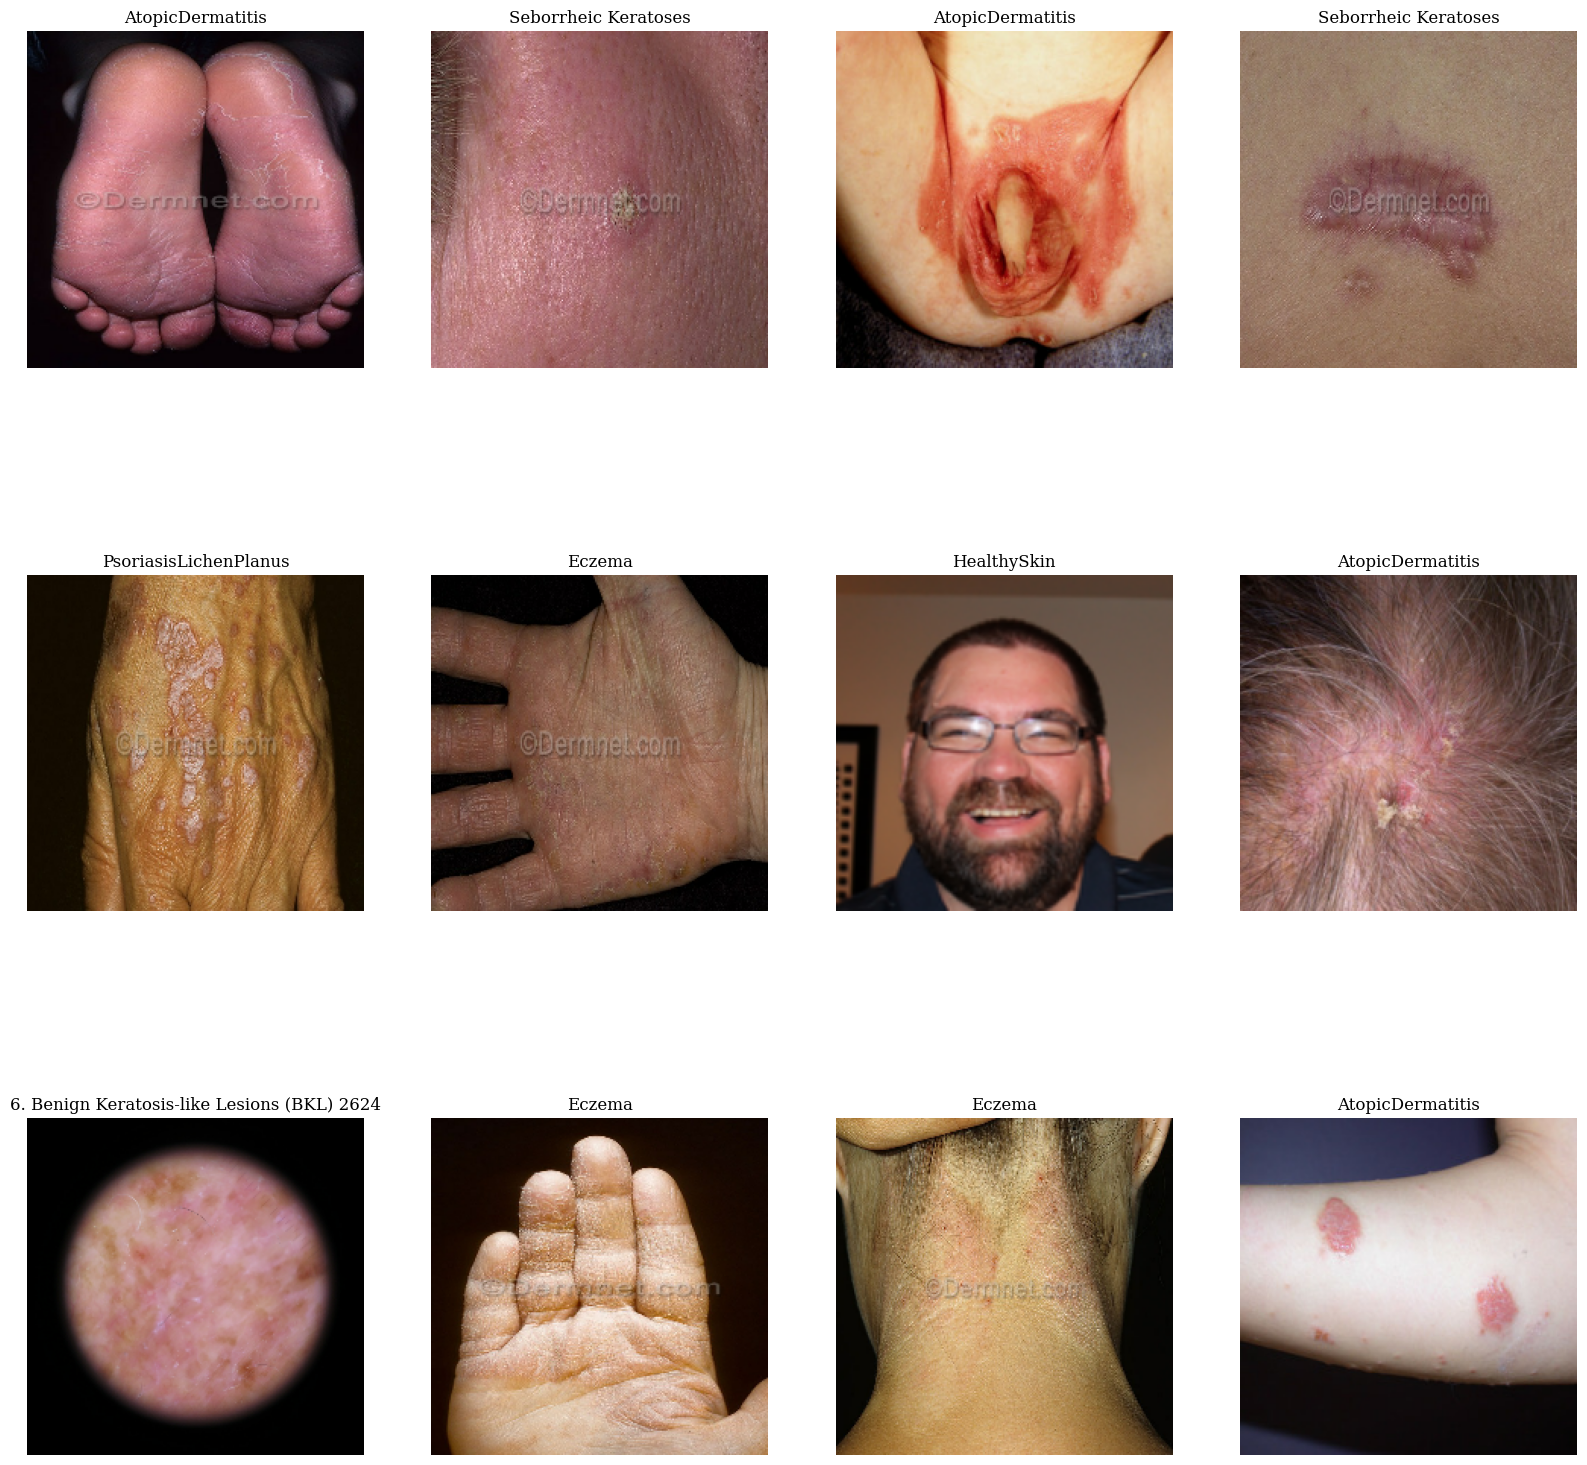

In [323]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 
    

In [324]:
len(dataset) 

310

In [325]:
train_size = 0.8
len(dataset)*train_size 

248.0

In [326]:
train_ds= dataset.take(248) 
len(train_ds)

248

In [327]:
test_ds = dataset.skip(248) 
len(test_ds)

62

In [328]:
val_size=0.1
len(dataset)*val_size

31.0

In [329]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [340]:
test_ds = test_ds.skip(31)
len(test_ds)

0

In [331]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    
    train_ds = ds.take(train_size)
    
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [332]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [333]:
len(train_ds)

248

In [334]:
len(val_ds)

31

In [335]:
len(test_ds)

31

In [341]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [342]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [343]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])



In [448]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])
model.build(input_shape=input_shape)

In [449]:
model.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 222, 222, 3)       0         
_________________________________________________________________
sequential_17 (Sequential)   (None, 222, 222, 3)       0         
_________________________________________________________________
conv2d_218 (Conv2D)          (32, 220, 220, 32)        896       
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (32, 110, 110, 32)        0         
_________________________________________________________________
conv2d_219 (Conv2D)          (32, 108, 108, 32)        9248      
_________________________________________________________________
max_pooling2d_219 (MaxPoolin (32, 54, 54, 32)          0         
_________________________________________________________________
conv2d_220 (Conv2D)          (32, 52, 52, 32)        

In [450]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [451]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
248/248 [==============================] - 237s 952ms/step - loss: 1.4230 - accuracy: 0.4378 - val_loss: 1.2224 - val_accuracy: 0.4922
Epoch 2/5
248/248 [==============================] - 221s 893ms/step - loss: 1.1513 - accuracy: 0.5383 - val_loss: 1.0931 - val_accuracy: 0.5286
Epoch 3/5
248/248 [==============================] - 220s 888ms/step - loss: 1.0266 - accuracy: 0.5724 - val_loss: 1.1065 - val_accuracy: 0.5587
Epoch 4/5
248/248 [==============================] - 221s 890ms/step - loss: 0.9751 - accuracy: 0.5981 - val_loss: 1.1127 - val_accuracy: 0.5369
Epoch 5/5
248/248 [==============================] - 220s 886ms/step - loss: 0.9400 - accuracy: 0.6110 - val_loss: 0.9672 - val_accuracy: 0.5867


In [372]:
scores = model.evaluate(test_ds)

OverflowError: cannot convert float infinity to integer

In [362]:
scores

[0.5977718830108643, 0.7606250047683716]

In [363]:
history

In [364]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 248}

In [365]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [366]:
history.history['accuracy']

[0.4073605537414551,
 0.5191602110862732,
 0.5646895170211792,
 0.5985835194587708,
 0.6079423427581787]

In [367]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

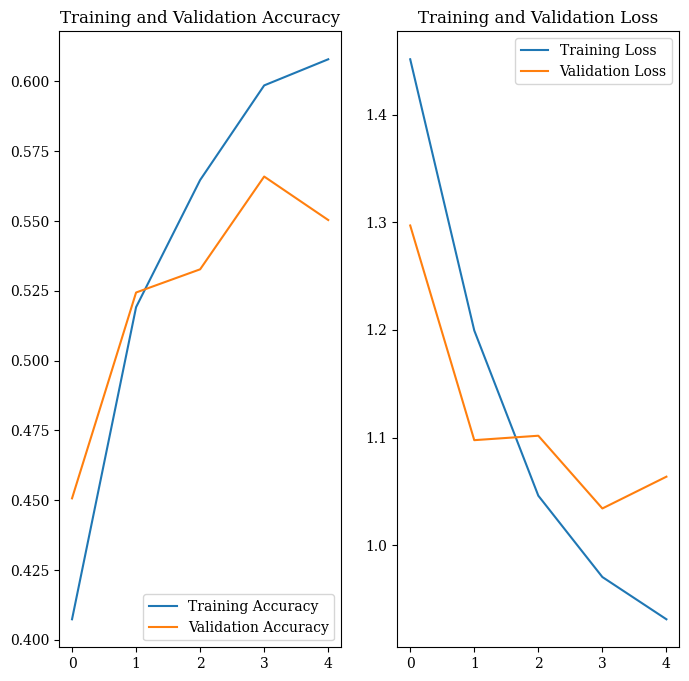

In [368]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [369]:
#import numpy as np
#for images_batch, labels_batch in test_ds.take(1):
    
    #first_image =images_batch[0].numpy().astype('uint8')
    #first_label = label_batch[0].numpy()
    
    #print("First image to Predict")
   # plt.imshow(first_image)
  #  print("actual label:",class_names[first_label])
    
 #   batch_prediction = model.predict(images_batch)
#    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#rounded_predictions = np.argmax(batch_predictions, axis=-1)

In [ ]:
#for i in rounded_predictions:
#    print(i)

In [252]:
#from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix
#import matplotlib

In [253]:
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [267]:
#plt.rc('font',family='Serif')

#mat = confusion_matrix()
#fig, ax = plot_confusion_matrix(conf_mat=mat, figsize=(6,6), class_names = class_names, show_normed=False)
#plt.tight_layout()
#fig.savefig('cm.png')

ValueError: Expected array-like (array or non-string sequence), got <PrefetchDataset shapes: ((None, 222, 222, 3), (None,)), types: (tf.float32, tf.int32)>